<a href="https://colab.research.google.com/github/pulavartivinay/Face_Mask_Detection/blob/model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# start

In [95]:
# installs

In [97]:
# imports
import tensorflow as tf
from keras.utils import plot_model
from keras import backend as K
import cv2
from google.colab.patches import cv2_imshow
import glob
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# loading dataset
# https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

!gdown --id 1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe #loading the dataset from google drive link to colab
!unzip /content/face-mask-12k.zip &> /dev/null #unzipping
!rm -rf /content/face-mask-12k.zip &> /dev/null #deleting the zip file
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe
To: /content/face-mask-12k.zip
351MB [00:03, 96.7MB/s]


In [ ]:
# finding the perfect crop size, for whole dataset
# https://stackoverflow.com/questions/19098104/python-opencv2-cv2-wrapper-to-get-image-size

def generate_image_paths(dir_path):
  files_png = glob.glob(dir_path + '/**/*.png', recursive=True)
  paths = list(files_png)
  return paths

train_dataset_path = "/content/face-mask-12k/Train"
val_dataset_path = "/content/face-mask-12k/Validation"

train_paths = generate_image_paths(train_dataset_path)
val_paths = generate_image_paths(val_dataset_path)

print(len(train_paths)) #output: 10000
print(len(val_paths))   #output: 800

def find_avg_height_and_width(paths):
  sum_height = 0
  sum_width = 0
  for path in paths:
    image = cv2.imread(path)
    height, width, channels = image.shape
    sum_height += height
    sum_width += width
  avg_height = sum_height//len(paths)
  avg_width = sum_width//len(paths)
  return (avg_height, avg_width)

print("Train avg height and width", find_avg_height_and_width(train_paths)) #output: (153, 153)
print("Validation avg height and width", find_avg_height_and_width(val_paths)) #output: (152, 152)

In [99]:
# hyper parameters
epochs = 3
batch_size = 32

In [100]:
# Preprocessing the data set into list of images
# https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Train",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Validation",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(153, 153),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

print("Train-dataset-length", len(train_dataset))
print("Validation-dataset-length", len(val_dataset))

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Train-dataset-length 313
Validation-dataset-length 25
Test-dataset-length 31


In [ ]:
# Model(Transfer Learning) (Later)

In [101]:
# Adding call Back Functions
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [103]:
# Main Model 

class MModel:
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.model = self.get_model()
    self.train_history = []
    self.val_history = []
    self.test_history = []

  def get_model(self):
    inputs = tf.keras.Input(shape=self.input_shape)  #input layer
    layer1 = tf.keras.layers.Conv2D(
        filters=2,
        kernel_size=4,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(inputs)
    layer2 = tf.keras.layers.Flatten()(layer1)
    outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(layer2)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.summary()
    plot_model(model, to_file='main_model_V040301.png') #convention for the model plot: main_model_VddMMXX where XX is the model number
    return model

  def compile(self, optimizer="adam", loss="binary_crossentropy", metrics=['acc', f1_m, precision_m, recall_m]):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def train(self, train_dataset, epochs=1):
    self.train_history = self.model.fit(train_dataset, epochs=epochs, verbose=1)

  def evaluate(self, val_dataset, batch_size="32"):
    self.val_history = self.model.evaluate(val_dataset, batch_size=32, verbose=1)

  def predict_single(self, path):
    image = tf.keras.preprocessing.image.load_img(path, grayscale=False, color_mode="rgb", target_size=(153, 153), interpolation="bilinear")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    p = self.model.predict(input_arr, verbose = 1)
    if p >= 0.5:
      return 1
    else:
      return 0

  def plot_loss_per_epoch(self):
    plt.plot(self.train_history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  def plot_accuracy_per_epoch(self):
    plt.plot(self.train_history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  def plot_f1_per_epoch(self):
    plt.plot(self.train_history.history['f1_m'])
    plt.plot(self.val_history[2])
    plt.title('model f1_score')
    plt.ylabel('f1_m')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
  
  def plot_precision_per_epoch(self):
    plt.plot(self.train_history.history['precision_m'])
    plt.plot(self.val_history[3])
    plt.title('model precision_score')
    plt.ylabel('precision_m')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  def plot_recall_per_epoch(self):
    plt.plot(self.train_history.history['recall_m'])
    plt.plot(self.val_history[4])
    plt.title('model recall_score')
    plt.ylabel('recall_m')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  def write_model_to_file(self, filename):
    self.model.save('./' + filename + '.h5')

In [104]:
# Creating instance of MModel Class

mmodel = MModel((153, 153, 3))

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 153, 153, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 150, 150, 2)       98        
_________________________________________________________________
flatten_9 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 45001     
Total params: 45,099
Trainable params: 45,099
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Model Compilation
# https://keras.io/api/models/model_training_apis/

mmodel.compile()

In [106]:
# Training
# https://keras.io/api/models/model_training_apis/

mmodel.train(train_dataset, epochs=epochs)

Epoch 1/3
313/313 [==============================] - 98s 309ms/step - loss: 459.6943 - acc: 0.7969 - f1_m: 0.7470 - precision_m: 0.7431 - recall_m: 0.7966
Epoch 2/3
313/313 [==============================] - 87s 277ms/step - loss: 7.7078 - acc: 0.9450 - f1_m: 0.9432 - precision_m: 0.9458 - recall_m: 0.9472
Epoch 3/3
313/313 [==============================] - 87s 278ms/step - loss: 3.1314 - acc: 0.9488 - f1_m: 0.9472 - precision_m: 0.9531 - recall_m: 0.9469


In [107]:
# model evaluation on val dataset
# https://keras.io/api/models/model_training_apis/

mmodel.evaluate(val_dataset)

25/25 [==============================] - 4s 134ms/step - loss: 6.8217 - acc: 0.9212 - f1_m: 0.9252 - precision_m: 0.8746 - recall_m: 0.9860


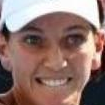

1/1 [==============================] - 0s 60ms/step
1


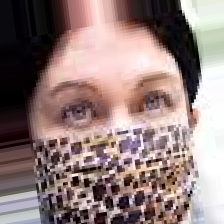

1/1 [==============================] - 0s 22ms/step
0


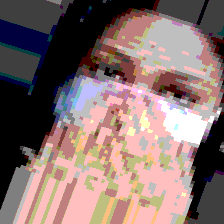

1/1 [==============================] - 0s 22ms/step
0


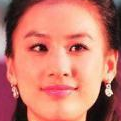

1/1 [==============================] - 0s 25ms/step
1


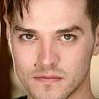

1/1 [==============================] - 0s 26ms/step
1


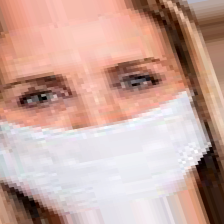

1/1 [==============================] - 0s 23ms/step
0


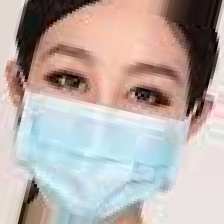

1/1 [==============================] - 0s 22ms/step
0


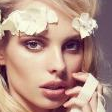

1/1 [==============================] - 0s 29ms/step
1


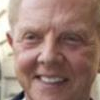

1/1 [==============================] - 0s 23ms/step
1


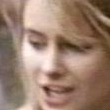

1/1 [==============================] - 0s 17ms/step
1


In [108]:
# Predictions of Validation data set(Dev) - visualisation

random.shuffle(val_paths)
for path in val_paths[:10]:
  image = cv2.imread(path)
  cv2_imshow(image)
  print(mmodel.predict_single(path))

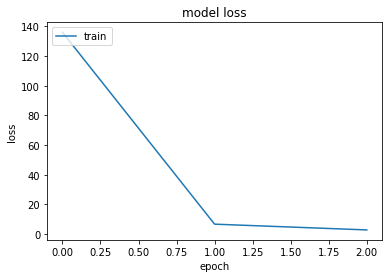

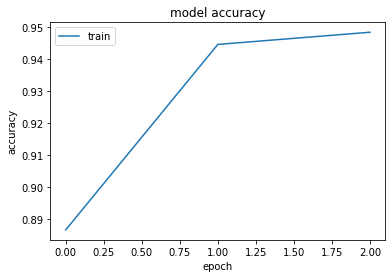

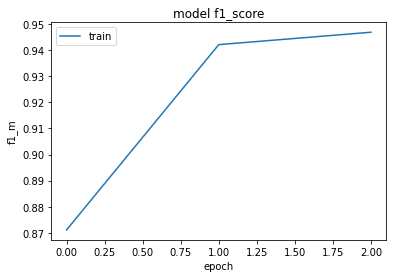

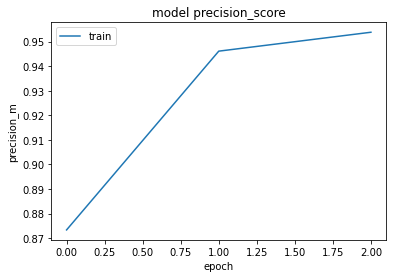

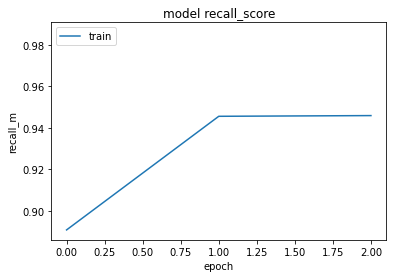

In [109]:
# Drawing the train Loss, accuracy, f1, precision, recall of the model - visualising

mmodel.plot_loss_per_epoch()
mmodel.plot_accuracy_per_epoch()
mmodel.plot_f1_per_epoch()
mmodel.plot_precision_per_epoch()
mmodel.plot_recall_per_epoch()

In [110]:
# saving model to file

mmodel.write_model_to_file('model0')